In [10]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import numpy as np
sns.set(rc={'figure.figsize':(16, 9)})
%config InlineBackend.figure_format = 'retina'

In [2]:
metadata = pd.read_csv("../raw-data/meta.csv", index_col=0).rename(columns={"address.lat": "lat", "address.lon": "lon"})
metadata["lat"] = metadata["lat"].str.replace(",", ".").astype(float)
metadata["lon"] = metadata["lon"].str.replace(",", ".").astype(float)
metadata.head()

,system,brand,name,address.str,lat,lon
id,,,,,,
3,11,bike_itau,P01 - Andrés Bello / Gral. Holley,"General Holley 41, esquina sur oriente con A. ...",-33.41935,-70.60962
4,11,bike_itau,P02 - Italia / Marín,"Italia 980, esquina NO con Marín",-33.44393,-70.62565
5,11,bike_itau,P03 - Suecia / El Vergel,"El Vergel 2316, esquina NO con Suecia",-33.43282,-70.60363
6,11,bike_itau,P04 - Costanera Center 1,"Nueva Tobalaba 12, Vereda Poniente frente a Co...",-33.41717,-70.60550
7,11,bike_itau,P05 - Costanera Center 2,"Nueva Tobalaba 12, junto a ciclovía",-33.41705,-70.60497


In [3]:
timeseries = pd.read_csv("../raw-data/timeseries.csv").rename(columns={"id": "station_id"})
# read the unix timestamp column as datetime
timeseries["time"] = pd.to_datetime(timeseries["time"], unit="s")
timeseries.tail()

,station_id,time,bikes,docks,is_online
189941,288,2022-11-15 02:17:15,10,1,True
189942,46,2022-11-15 02:19:44,25,2,True
189943,202,2022-11-15 02:19:38,7,8,True
189944,78,2022-11-15 02:24:59,13,1,True
189945,78,2022-11-15 02:29:23,12,2,True


In [4]:
station_availability = pd.DataFrame(columns=["station_id", "hour", "day", "availability", "threshold"])
# Iterate over all stations, resample the timeseries to 1m intervals 
# and for each hour, count the proportion of times when the station 
# had more than `threshold` bikes available
unique_stations = timeseries["station_id"].unique()
for station_id in tqdm(unique_stations):
    station_timeseries = timeseries[timeseries["station_id"] == station_id]
    station_timeseries = station_timeseries.drop_duplicates(subset=["station_id", "time"]).set_index("time").resample("1min").ffill()
    station_timeseries["hour"] = station_timeseries.index.hour
    station_timeseries["day"] = station_timeseries.index.dayofweek
    for available_bikes_threshold in range(1, 11):
        station_timeseries["availability"] = station_timeseries["bikes"] >= available_bikes_threshold
        station_timeseries_g = station_timeseries.groupby(["hour", "day"])["availability"].mean().reset_index()
        station_timeseries_g["station_id"] = station_id
        station_timeseries_g["threshold"] = available_bikes_threshold
        station_availability = station_availability.append(station_timeseries_g)

100%|██████████| 245/245 [00:59<00:00,  4.13it/s]


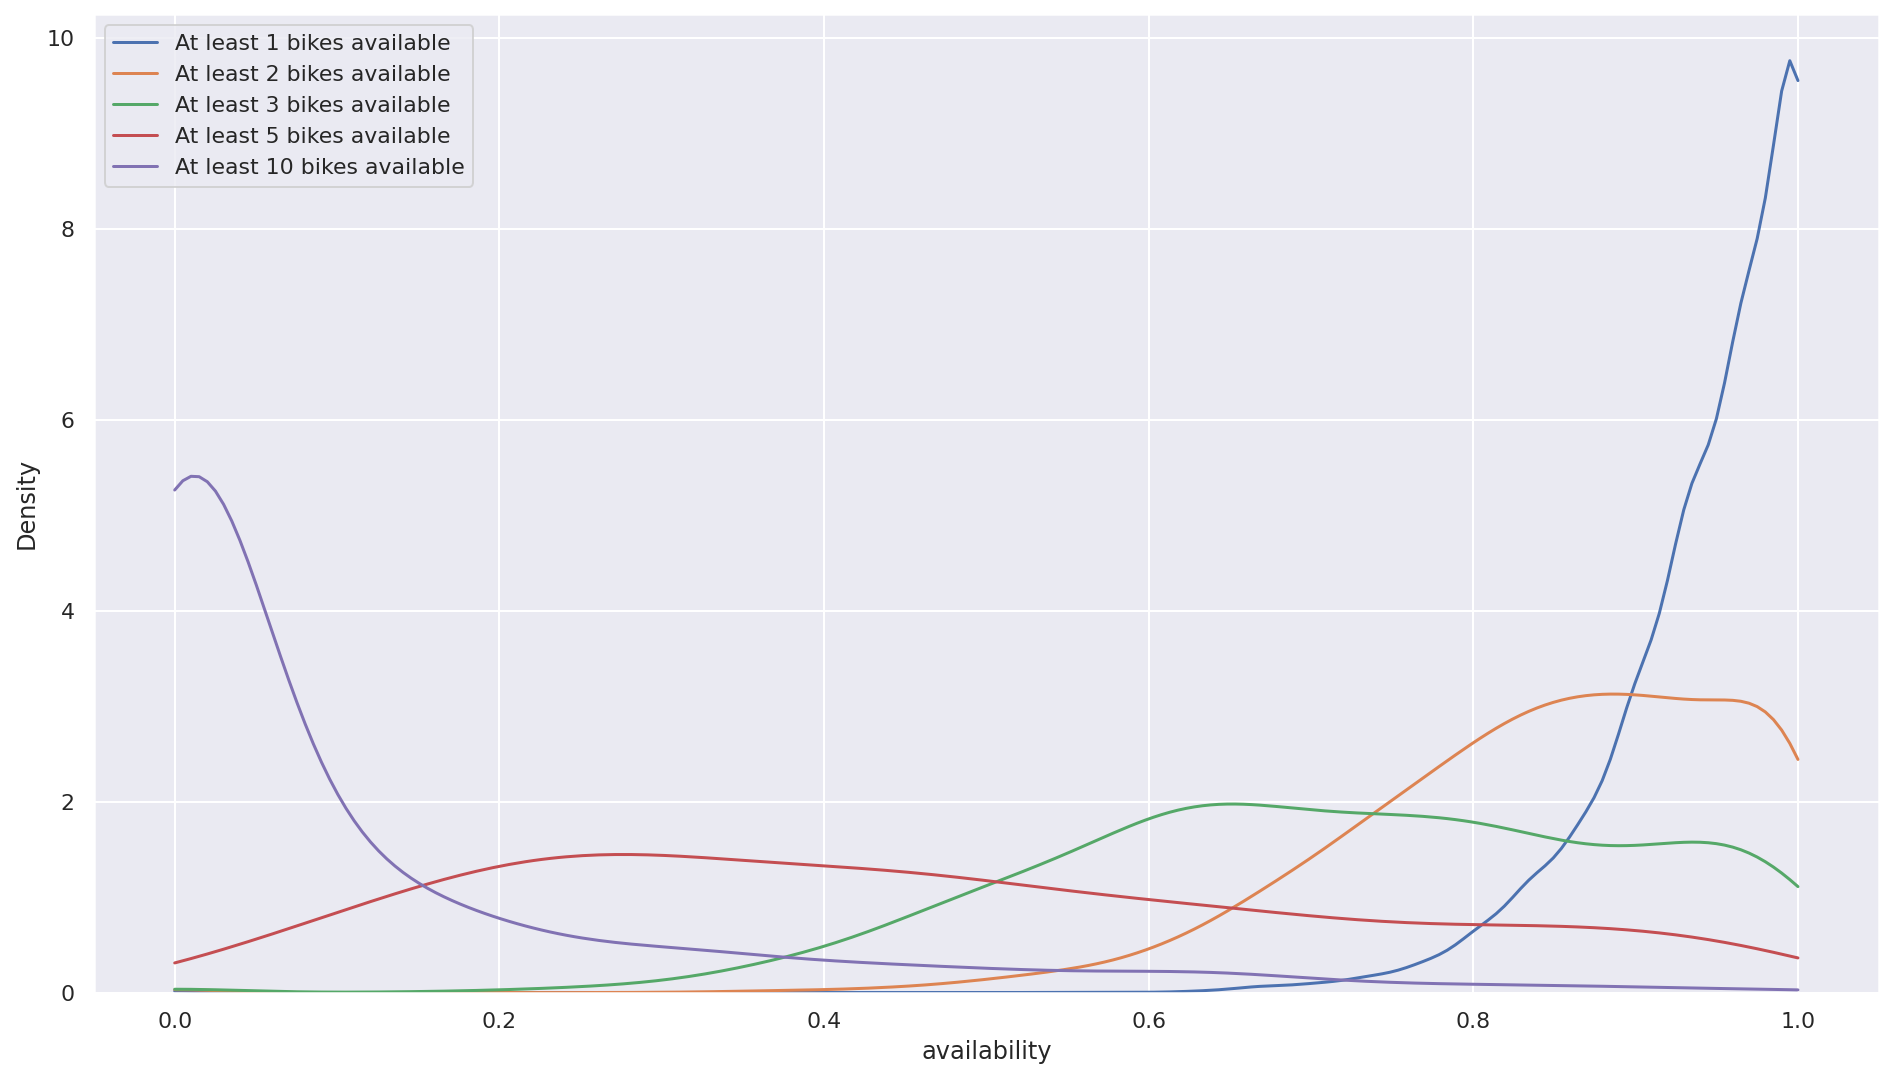

In [5]:
for threshold in [1, 2, 3, 5, 10]:
    sns.kdeplot(station_availability[station_availability["threshold"] == threshold].reset_index().availability, clip=(0,1), bw_adjust=2, label=f"At least {threshold} bikes available")
plt.legend(loc='upper left')

<AxesSubplot:xlabel='hour', ylabel='availability'>

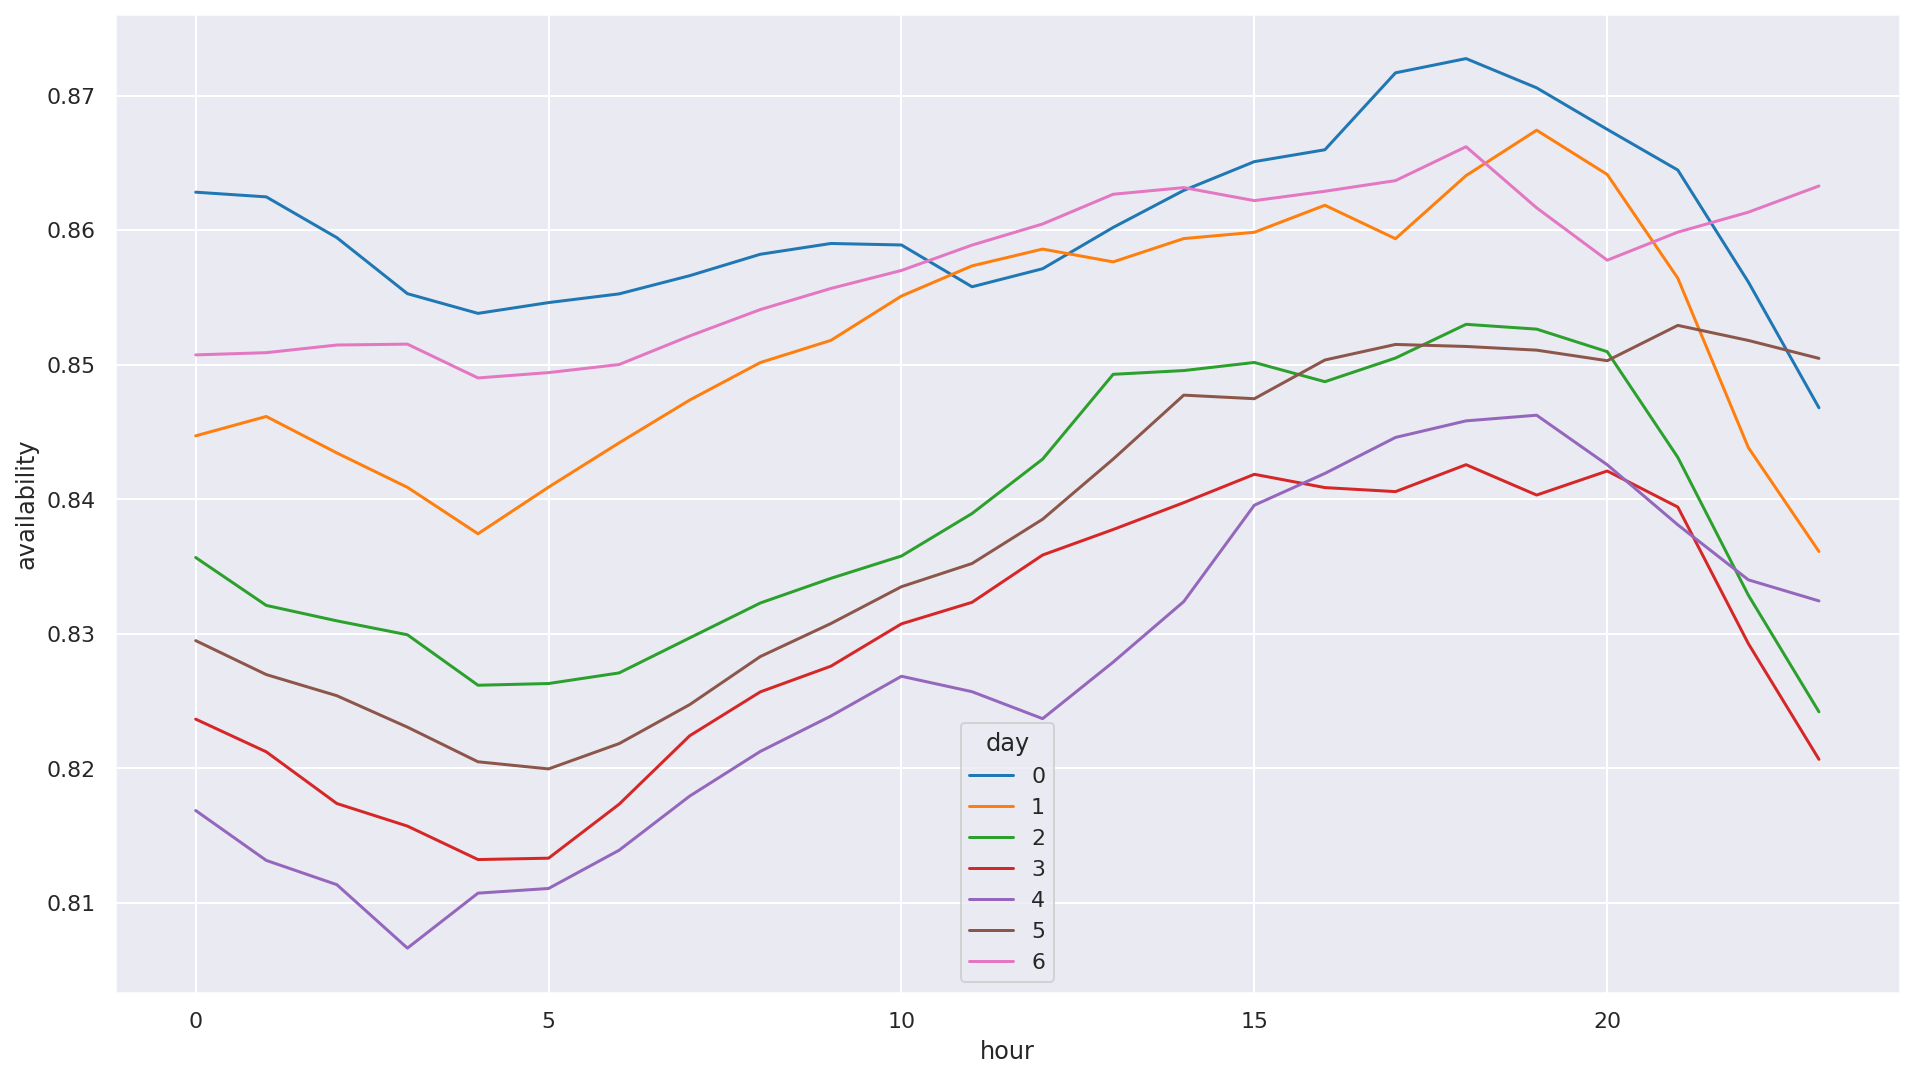

In [6]:
sns.lineplot(data=station_availability[(station_availability["threshold"] == 2)].groupby(["day", "hour"]).mean(), x="hour", y="availability", hue="day", palette="tab10")

In [13]:
# station_timeseries = timeseries[(timeseries["station_id"] == 167) & (timeseries["time"] > "2022-11-01 01:00")]
# station_timeseries = station_timeseries.set_index("time").resample("1min").ffill()
# station_timeseries.head(60)

In [12]:
fig = ff.create_hexbin_mapbox(
    lat=metadata.lat, lon=metadata.lon, nx_hexagon=15, # animation_frame=frame,
    color_continuous_scale="Cividis", labels={"color": "Point Count", "frame": "Period"},
    opacity=0.5, min_count=1,
    show_original_data=True, original_data_marker=dict(opacity=1, size=5, color="deeppink")
)
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0), mapbox_style="open-street-map")
# fig.layout.sliders[0].pad.t=20
# fig.layout.updatemenus[0].pad.t=40
fig.show()


In [18]:
station_availability[["day", "hour", "threshold", "station_id", "availability"]].to_csv("../processed-data/station_bike_availability.csv", index=False, float_format='%.3f')